## Experiment Results Analysis

In this experiment, we executed 3 different algorithms for Sparse Matrix Multiplication, nameley the *sparse-sparse dot-product*, *sparse-dense dot-product*, and *accumulator* methods. Each method was used to multiply 3 sets of matrices, at 4 different fill factors, and using $1--28$ threads.

- Matrices
    * A: 10K x 10K, B: 10K x 10K
    * A: 20K x 5.3K, B: 5.3K x 50K
    * A: 9K x 35K, B: 35K x 5.75K
- Fill Factor: 5%, 10%, 15%, and 20% non-zeros
- Number of threads: 1, 2, 4, 8, 12, 14, 16, 20, 24, 28.

To minimize dependence on a particular matrix structure, matrices A and B were randomly generated for each experiment, both with regards to the non-zero values and their placement within the matrices. Furthermore, to more realistically mimic real-world data experiments, B^T was given as input to the program, i.e., both A and B^T had samples as rows with the same number of features (dimensions).

The sparse matrix multiplication program written for this experiment used the following parameters:
```bash
sparsematmult <A_nrows> <A_ncols> <B_ncols> <fill_factor> [-n <tile_size>] [-t <num_treads>]
```
For each execution of the program, all three proposed matrix multiplication methods were executed and timing information for the search (including pre-processing of the input matrices) was reported, as seen in the example below. The `-t` parameter allowed choosing the number of threads that would be used to solve the problem. The `-n` parameter set the number of consecutive rows of `A` that each thread would multiply at a time, which dictated the amount of memory needed for the workspace of each thread.
```bash
david@xps-15:~/pr2$ sparsematmult 9000 35000 5750 0.05 -n 1 -t 1
A_nrows: 9000
A_ncols: 35000
B_ncols: 5750
factor: 0.05
tile size: 1
nthreads: 1
A<9000, 35000, 15750000>
B<5750, 35000, 10062500>
C1<9000, 5750, 50827794>
Execution time (sparse-sparse dot-product): 703.897
C2<9000, 5750, 50827794>
Execution time (sparse-dense dot-product): 110.971
C3<9000, 5750, 50827794>
Execution time (accumulator): 12.4969
C1 == C2: true
C2 == C3: true
```

### Batch Execution on WAVE HPC
All experiments were executed on the GPU nodes of the HPC (to prevent interference with the experiments students were running on the compute nodes). The following Slurm batch job file was used to run the experiments:
```bash
#!/bin/bash
#SBATCH --job-name="spgemm"
#SBATCH --output="spgemm.%j.%N.out"
#SBATCH --partition=gpu
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=56
#SBATCH --mem=112G
#SBATCH --export=ALL
#SBATCH -t 48:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=danastasiu@scu.edu

module load GCC/10

export OMP_PLACES=cores
export OMP_PROC_BIND=close

DIR=/WAVE/users/unix/danastasiu/pr2-solution
LOGDIR="${DIR}/logs"

for f in 0.20 0.15 0.10 0.05; do
  for t in 28 24 20 16 14 12 8 4 2 1; do
    for n in 1 50 100; do
      LF="spgemm-10K-${f}-${t}-${n}.log"
      if [ ! -f "${LOGDIR}/${LF}" ]; then
        echo ${LF%4}
        ${DIR}/sparsematmult 10000 10000 10000 ${f} -t ${t} -n ${n} > ${LOGDIR}/${LF}
      fi
      LF="spgemm-9K-${f}-${t}-${n}.log"
      if [ ! -f "${LOGDIR}/${LF}" ]; then
        echo ${LF%4}
        ${DIR}/sparsematmult 9000 35000 5750 ${f} -t ${t} -n ${n} > ${LOGDIR}/${LF}
      fi
      LF="spgemm-20K-${f}-${t}-${n}.log"
      if [ ! -f "${LOGDIR}/${LF}" ]; then
        echo ${LF%4}
        ${DIR}/sparsematmult 20000 5300 50000 ${f} -t ${t} -n ${n} > ${LOGDIR}/${LF}
      fi
    done
  done
done
```
Note that each experiment writes their results to a separate log file within the logs directory. In the following, we will parse those logs and read all the important details about each experiment.

In [1]:
from os import walk
from os.path import join
import pandas as pd

def parse_log(filename, fdir, data):
    """Parse single experiment log file"""
    key = filename[7:-4]
    # parse log file
    int_params = {
        'A_nrows': 'A_nrows',
        'A_ncols': 'A_ncols',
        'B_ncols': 'B_ncols',
        'tile size': 'tile_size',
        'nthreads': 'nthreads'
    }
    float_params = {
        'factor': 'fill_factor',
        'Execution time (sparse-sparse dot-product)': 'ssdp',
        'Execution time (sparse-dense dot-product)': 'sddp',
        'Execution time (accumulator)': 'accum'
    }
    d = {}
    with open(join(fdir, filename), 'r') as fh:
        for l in fh:
            if ':' in l:
                p = l.strip().split(':')
                if len(p) == 2:
                    if p[0] in int_params:
                        d[int_params[p[0]]] = int(p[1])
                    elif p[0] in float_params:
                        d[float_params[p[0]]] = float(p[1])
    # add to results collection only if log is complete
    if 'accum' in d:
        data[key] = d
    else:
        print(f'{key} missing data')

fdir='logs'
data = {}
(_, _, filenames) = next(walk(fdir))
for f in filenames:
    parse_log(f, fdir, data)
df = pd.DataFrame.from_dict(data, orient='index')

In [2]:
df

,A_nrows,A_ncols,B_ncols,fill_factor,tile_size,nthreads,ssdp,sddp,accum
10K-0.15-20-50,10000,10000,10000,0.15,50,20,65.3891,10.55450,3.089340
9K-0.20-28-1,9000,35000,5750,0.20,1,28,144.0640,20.96740,12.181300
20K-0.15-24-1,20000,5300,50000,0.15,1,24,360.5950,47.99890,19.224200
10K-0.20-8-50,10000,10000,10000,0.20,50,8,204.2880,31.97330,11.288900
9K-0.15-8-100,9000,35000,5750,0.15,100,8,287.8360,46.87850,13.060700
...,...,...,...,...,...,...,...,...,...
10K-0.05-4-100,10000,10000,10000,0.05,100,4,104.8180,16.18000,1.726960
10K-0.05-28-1,10000,10000,10000,0.05,1,28,21.4614,2.61401,0.625086
9K-0.10-8-100,9000,35000,5750,0.10,100,8,196.5330,31.45220,6.477480
10K-0.20-16-100,10000,10000,10000,0.20,100,16,114.6370,18.66560,6.430150


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot3D(x, y, z, title=None, xaxis=None, yaxis=None, zaxis=None, cmap='hot', fname=None):
    """Create a 3D plot."""
    fig = plt.figure(figsize =(16, 9))
    ax = plt.axes(projection ='3d')
    my_cmap = plt.get_cmap('hot')
    ts = ax.plot_trisurf(x, y, z,
                         cmap = my_cmap,
                         linewidth = 0.2,
                         antialiased = True,
                         edgecolor = 'grey')
    
    # Show color bar
    fig.colorbar(ts, ax = ax, shrink = 0.5, aspect = 12)
    # Set title
    if title is not None:
        ax.set_title(title, fontweight='bold', fontsize=14)
    # Add labels
    if xaxis is None:
        xaxis = 'x-axis'
    if yaxis is None:
        yaxis = 'y-axis'
    if zaxis is None:
        zaxis = 'z-axis'
    ax.set_xlabel(xaxis, fontweight='bold')
    ax.set_ylabel(yaxis, fontweight='bold')
    ax.set_zlabel(zaxis, fontweight='bold')
    if fname:
        plt.tight_layout()
        fig.savefig(fname)
    return fig

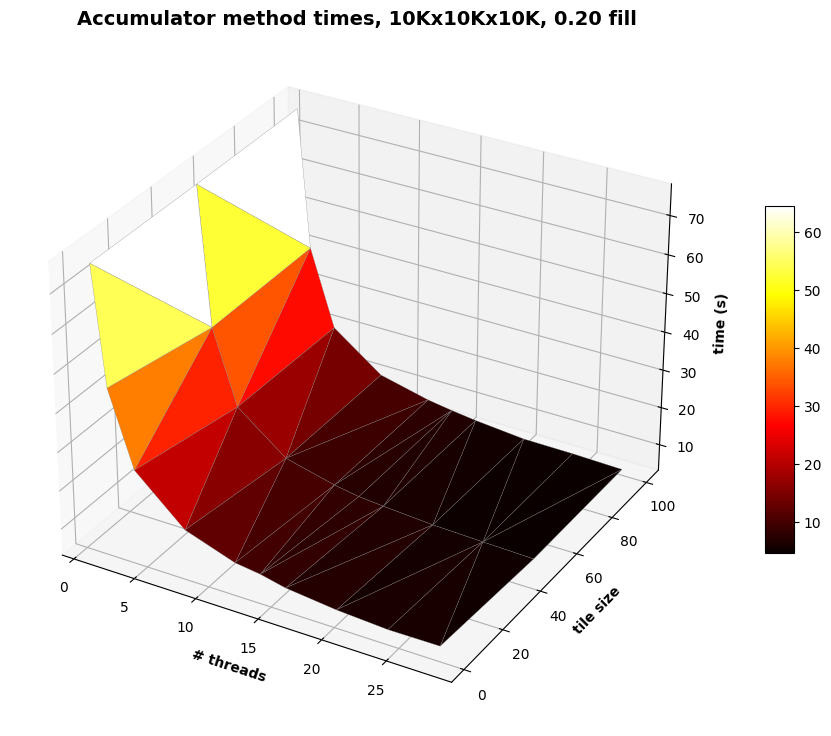

In [4]:
df1 = df[(df.fill_factor == 0.20) & (df.A_nrows == 10000)]
plot3D(
    df1.nthreads, 
    df1.tile_size, 
    df1.accum, 
    xaxis='# threads',
    yaxis='tile size',
    zaxis='time (s)',
    title="Accumulator method times, 10Kx10Kx10K, 0.20 fill")

plt.show()

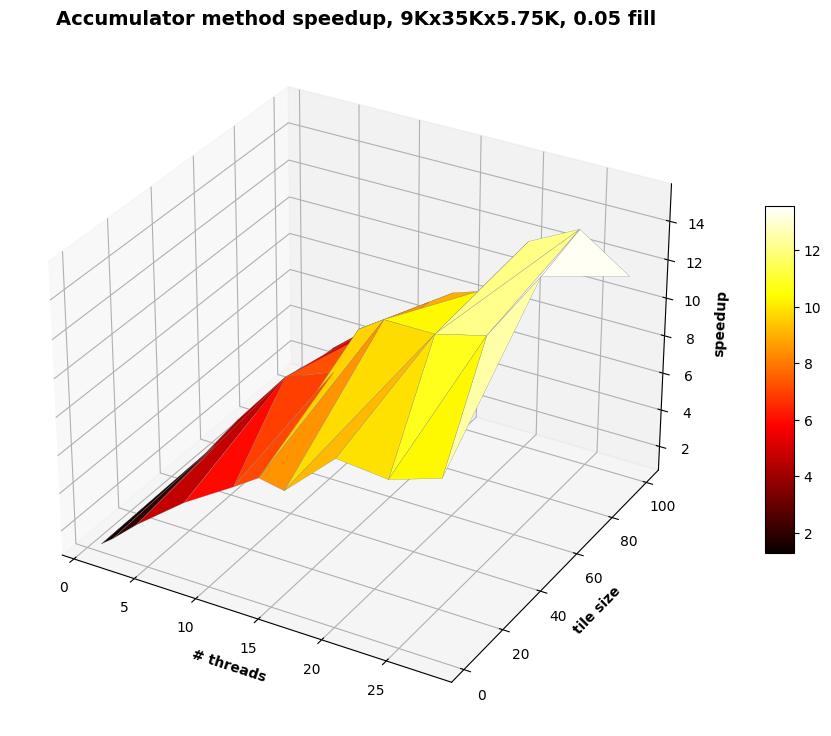

In [5]:
df1 = df[(df.fill_factor == 0.05) & (df.A_nrows == 9000)].copy()
df1['serial'] = 0.0
for ts in df1.tile_size.unique():
    serial = df1.loc[(df1.nthreads == 1) & (df1.tile_size == ts), 'accum']
    df1.loc[df1.tile_size == ts, 'serial'] = serial.get(0)
df1['speedup'] = df1['serial']/df1['accum']
plot3D(
    df1.nthreads, 
    df1.tile_size, 
    df1['speedup'], 
    xaxis='# threads',
    yaxis='tile size',
    zaxis='speedup',
    title="Accumulator method speedup, 9Kx35Kx5.75K, 0.05 fill")

plt.show()

In [6]:
matrices = {
    9000: '9Kx35Kx5.75K',
    10000: '10Kx10Kx10K',
    20000: '20Kx5.3Kx50K'
}
method_names = {
    'accum': 'Accumulator',
    'ssdp': 'Sparse-sparse dot-product',
    'sddp': 'Sparse-dense dot-product',
}
# Create figures showing time-based performance for all experiments
for mat in [9000, 10000, 20000]:
    for method in ['accum', 'ssdp', 'sddp']:
        for ff in [0.05, 0.10, 0.15, 0.20]:
            df1 = df[(df.fill_factor == ff) & (df.A_nrows == mat)]
            fig = plot3D(
                    df1.nthreads, 
                    df1.tile_size, 
                    df1[method], 
                    xaxis='# threads',
                    yaxis='tile size',
                    zaxis='time (s)',
                    title=f"{method_names[method]} method times, {matrices[mat]}, {ff:0.2f} fill",
                    fname=f"charts/time-{method}-{mat/1000}K-{ff:0.2f}.jpg"
                )
            plt.close(fig)

In [7]:
# Create figures showing speedup-based performance for all experiments
for mat in [9000, 10000, 20000]:
    for method in ['accum', 'ssdp', 'sddp']:
        for ff in [0.05, 0.10, 0.15, 0.20]:
            df1 = df[(df.fill_factor == ff) & (df.A_nrows == mat)].copy()
            df1['serial'] = 0.0
            for ts in df1.tile_size.unique():
                serial = df1.loc[(df1.nthreads == 1) & (df1.tile_size == ts), method]
                df1.loc[df1.tile_size == ts, 'serial'] = serial.get(0)
            df1['speedup'] = df1['serial']/df1[method]
            fig = plot3D(
                    df1.nthreads, 
                    df1.tile_size, 
                    df1['speedup'], 
                    xaxis='# threads',
                    yaxis='tile size',
                    zaxis='speedup',
                    title=f"{method_names[method]} method speedup, {matrices[mat]}, {ff:0.2f} fill",
                    fname=f"charts/speedup-{method}-{mat/1000}K-{ff:0.2f}.jpg"
                )
            plt.close(fig)

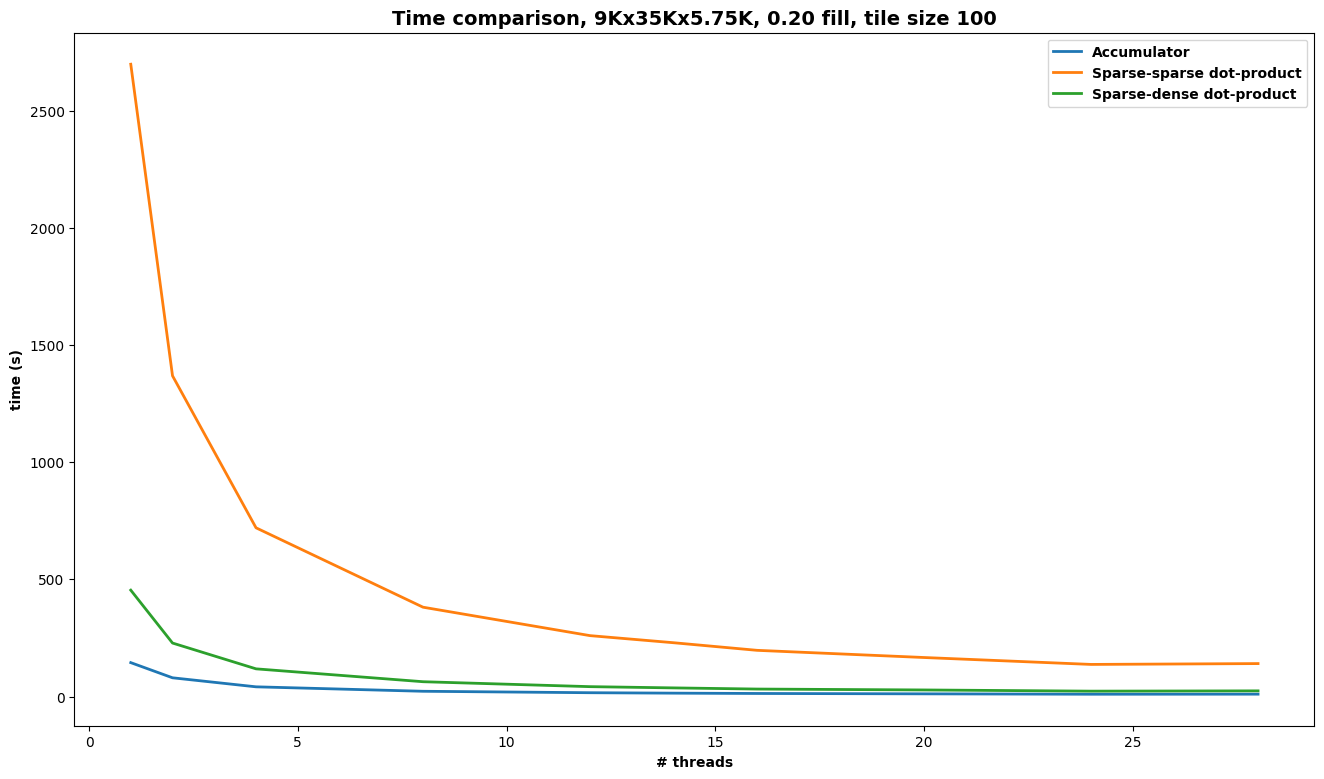

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison(df, mat=9000, fill_factor=0.20, tile_size=100, fname=None):
    """Compare times of the three methods for a given fill factor and tile size."""
    fig = plt.figure(figsize =(16, 9))
    ax = plt.axes()
    methods = ['accum', 'ssdp', 'sddp']
    for method in methods:
        df1 = df[(df.fill_factor == fill_factor) & (df.tile_size == tile_size) & (df.A_nrows == mat)].sort_values(by=['nthreads'])
        ax.plot(df1.nthreads, df1[method], label=method_names[method], linewidth=2, markersize=10)
    # Set title
    ax.set_title(f"Time comparison, {matrices[mat]}, {fill_factor:0.2f} fill, tile size {tile_size}", fontweight='bold', fontsize=14)
    # Add labels
    ax.set_xlabel('# threads', fontweight='bold')
    ax.set_ylabel('time (s)', fontweight='bold')
    plt.legend([method_names[method] for method in methods], loc=0, fontsize=13, prop={'weight':'bold'})
    if fname:
        plt.tight_layout()
        fig.savefig(fname)
    return fig
fig = plot_comparison(df)
plt.show()

In [9]:
# Create time comparison plots for all matrices and fill factors
for mat in [9000, 10000, 20000]:
    for ff in [0.05, 0.10, 0.15, 0.20]:
        for ts in [1, 50, 100]:
            fig = plot_comparison(df, mat=mat, fill_factor=ff, tile_size=ts,
                                  fname=f"charts/cmp-time-{mat/1000}K-{ff:0.2f}-{ts}.jpg")
            plt.close(fig)

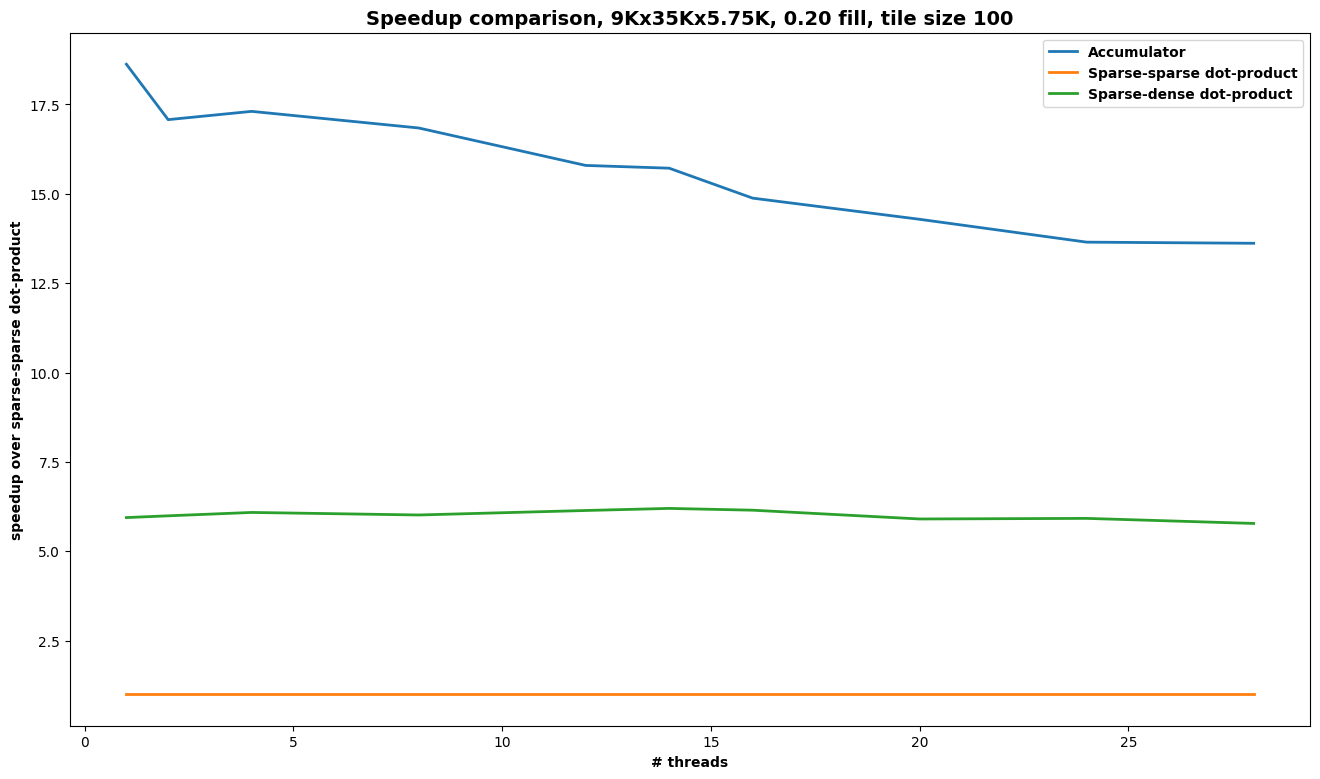

In [10]:

def speedup_comparison(df, mat=9000, fill_factor=0.20, tile_size=100, fname=None):
    """Compare speedup over sparse-sparse dot-product for a given fill factor and tile size."""
    fig = plt.figure(figsize =(16, 9))
    ax = plt.axes()
    methods = ['accum', 'ssdp', 'sddp']
    for method in methods:
        df1 = df[(df.fill_factor == fill_factor) & (df.tile_size == tile_size) & (df.A_nrows == mat)].sort_values(by=['nthreads'])
        ax.plot(df1.nthreads, df1['ssdp']/df1[method], label=method_names[method], linewidth=2, markersize=10)
    # Set title
    ax.set_title(f"Speedup comparison, {matrices[mat]}, {fill_factor:0.2f} fill, tile size {tile_size}", fontweight='bold', fontsize=14)
    # Add labels
    ax.set_xlabel('# threads', fontweight='bold')
    ax.set_ylabel('speedup over sparse-sparse dot-product', fontweight='bold')
    plt.legend([method_names[method] for method in methods], loc=0, fontsize=13, prop={'weight':'bold'})
    if fname:
        plt.tight_layout()
        fig.savefig(fname)
    return fig
fig = speedup_comparison(df)
plt.show()

In [11]:
# Create time comparison plots for all matrices and fill factors
for mat in [9000, 10000, 20000]:
    for ff in [0.05, 0.10, 0.15, 0.20]:
        for ts in [1, 50, 100]:
            fig = speedup_comparison(df, mat=mat, fill_factor=ff, tile_size=ts,
                                     fname=f"charts/cmp-speedup-{mat/1000}K-{ff:0.2f}-{ts}.jpg")
            plt.close(fig)